# 微调 改变了计算机视觉任务或nlp的重要任务


# 微调是迁移学习的常见技巧 


迁移学习是一种机器学习技术，它利用在一个任务上训练好的模型，将其知识迁移到另一个相关任务上，从而提高目标任务的性能。它特别适用于数据量有限的任务，通过使用在大型数据集上预训练的模型（如ImageNet上的模型），可以显著减少目标任务的训练时间，并提高模型的精度。

迁移学习主要有以下几个步骤：

选择预训练模型：在大型数据集上预训练的模型（如ResNet、VGG等）。
调整模型：根据目标任务的需求，微调模型的最后几层或添加新的层。
训练和优化：在目标数据集上训练调整后的模型。
这种方法在图像分类、自然语言处理等领域应用广泛。

# 标注一个数据集使非常贵的一件事

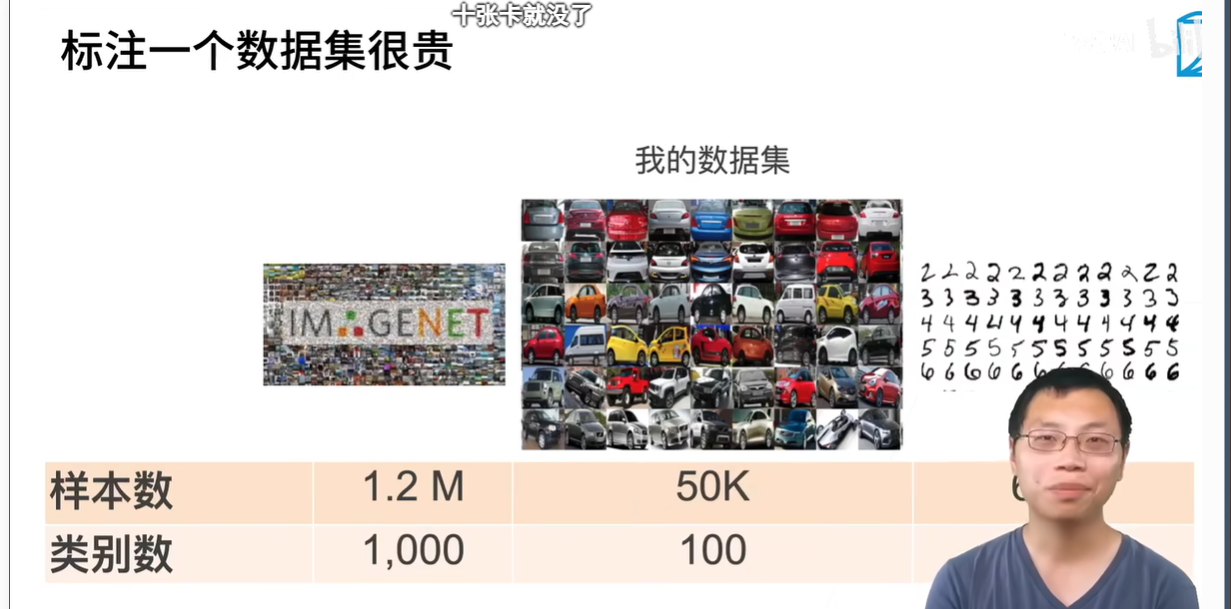

# 网络架构

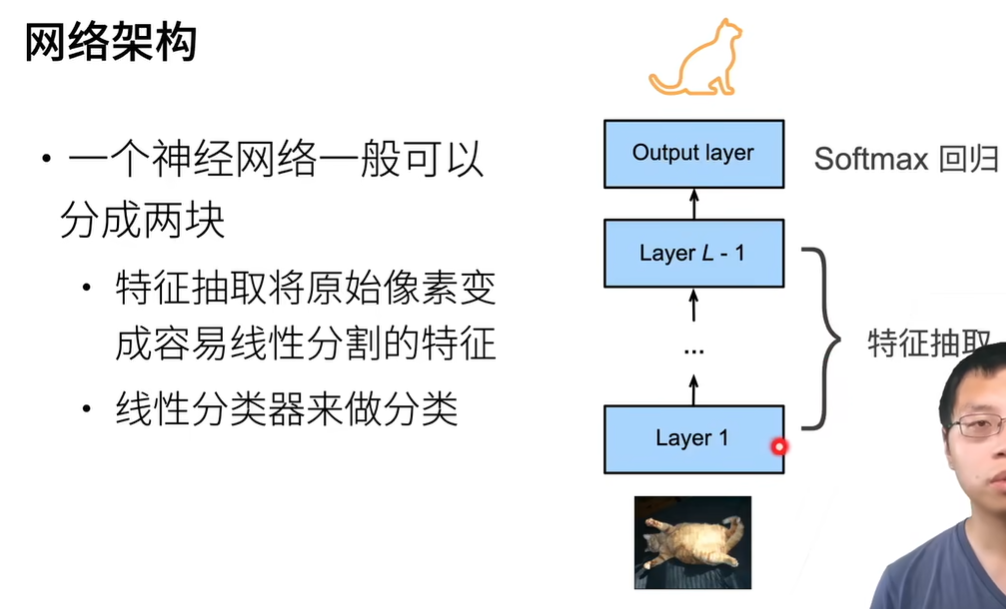

# 微调

1.在源数据集上训练好了一些模型
但也在目标数据集上应该起作用 但是不行

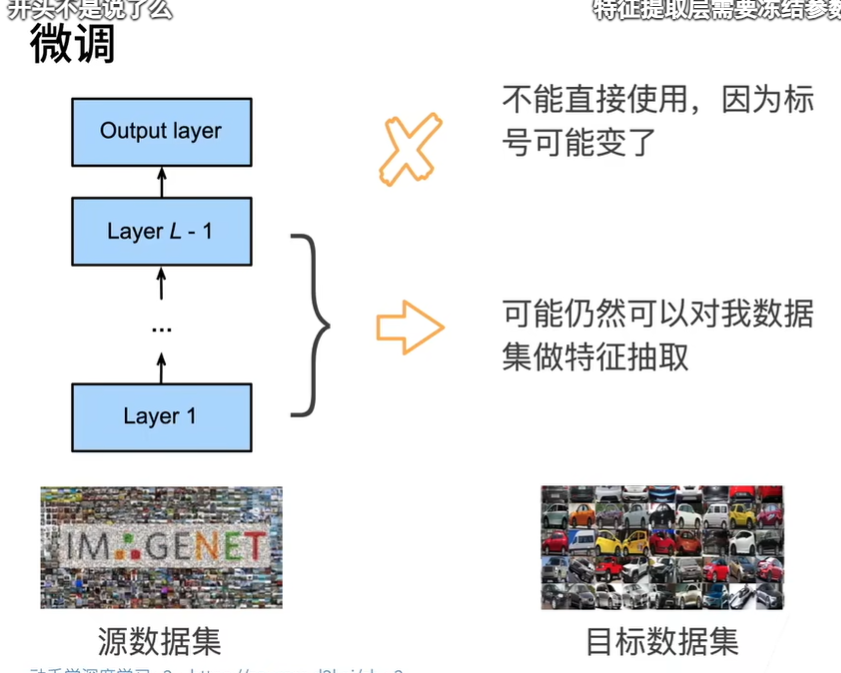

# 权重中的权重初始化

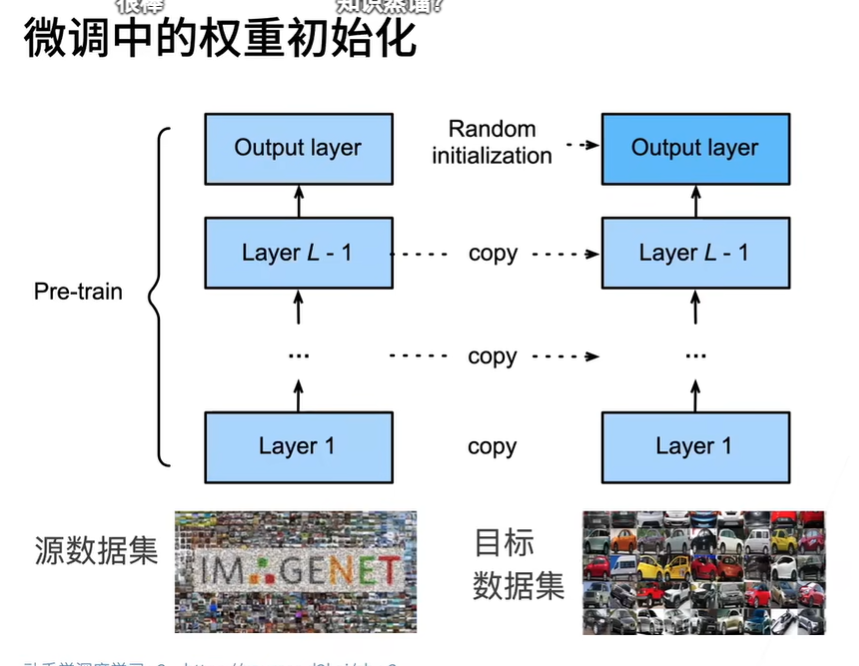

# 微调的步骤

1.在源数据集（例如ImageNet数据集）上预训练神经网络模型，即源模型。

2.创建一个新的神经网络模型，即目标模型。这将复制源模型上的所有模型设计及其参数（输出层除外）。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适用于目标数据集。我们还假设源模型的输出层与源数据集的标签密切相关；因此不在目标模型中使用该层。

3.向目标模型添加输出层，其输出数是目标数据集中的类别数。然后随机初始化该层的模型参数

4.在目标数据集（如椅子数据集）上训练目标模型。输出层将从头开始进行训练，而所有其他层的参数将根据源模型的参数进行微调。

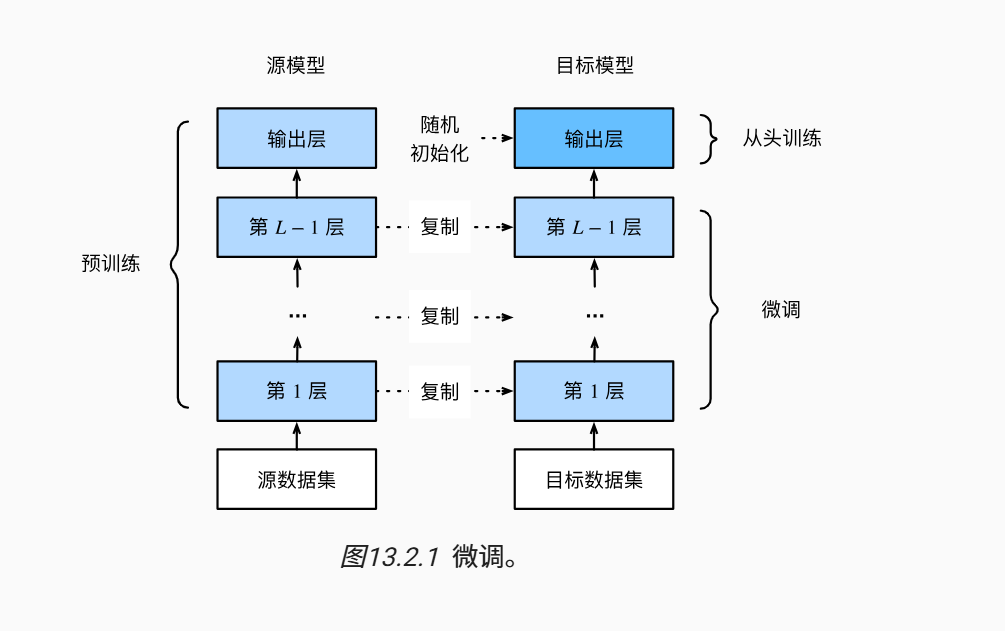

# 训练

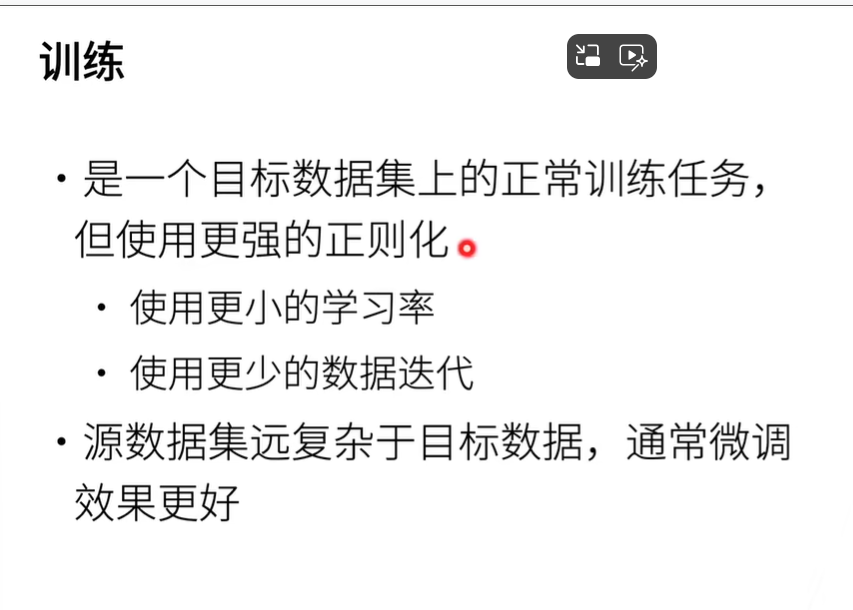

# 重用分类器权重

具体来说，在图像分类任务中，你可以使用在一个大型数据集（如ImageNet）上预训练的模型，并重用其权重来初始化你的模型。这些预训练的权重已经捕捉到了一般的特征表示，可以帮助你的模型在较小的目标数据集上更快收敛并取得更好的性能。

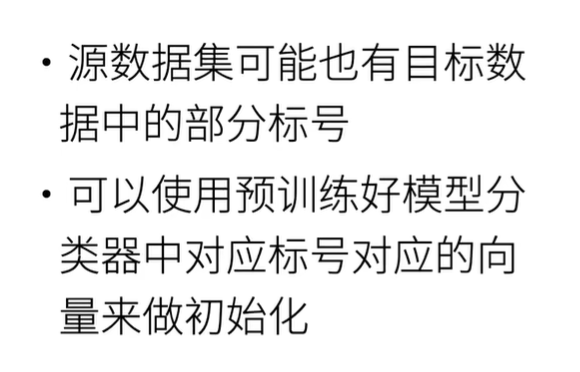

# 固定一些层

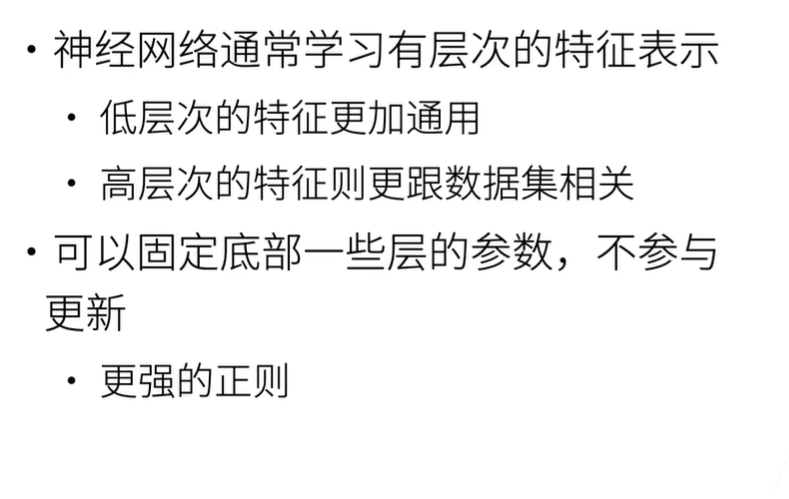

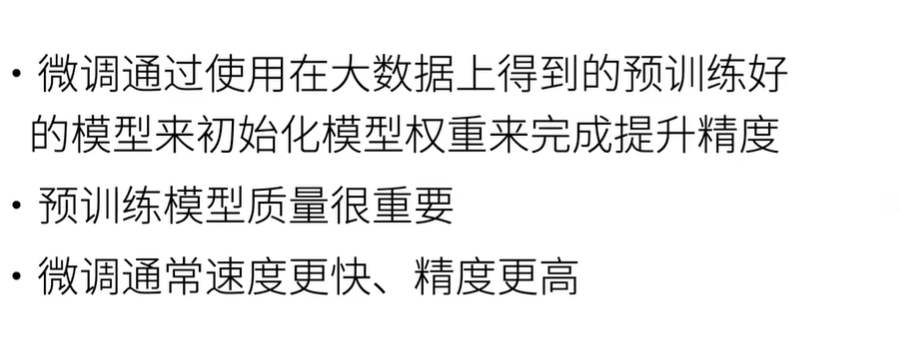

In [1]:
# 微调的代码
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
# 采用的是一类热狗数据集
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [3]:
#我们创建两个实例来分别读取训练和测试数据集中的所有图像文件

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

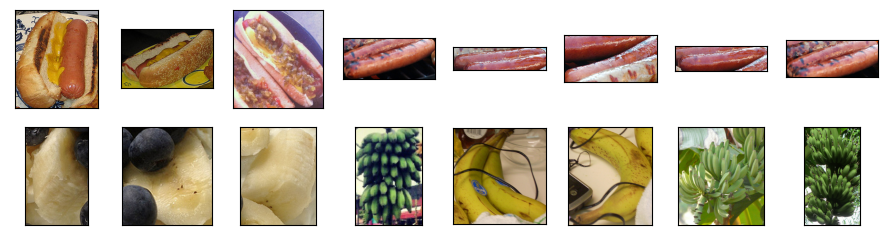

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [5]:
# 进行数据增广
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# 定义训练数据增强
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),   # 随机裁剪图像为224x224
    torchvision.transforms.RandomHorizontalFlip(),   # 随机水平翻转
    torchvision.transforms.ToTensor(),               # 转换为张量
    normalize                                        # 标准化
])

# 定义测试数据增强
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),       # 调整图像大小为256x256
    torchvision.transforms.CenterCrop(224),          # 中心裁剪图像为224x224
    torchvision.transforms.ToTensor(),               # 转换为张量
    normalize                                        # 标准化
])

In [9]:
# 定义和初始化模型 ResNet-18作为源模型
#加载一个预训练好的ResNet-18模型
#pretrained=True：表示加载一个在ImageNet数据集上预训练好的模型。
# 预训练好的模型已经在大量的图像上训练过，因此可以提供良好的初始权重，从而加速收敛，
# 并且在许多情况下可以提高模型的最终性能。
pretrained_net = torchvision.models.resnet18(pretrained=True)

D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\study\anaconda\envs\torch_pythom_3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Z/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [10]:
# 预训练的源模型实例包含许多特征层和一个输出层fc。 
# 此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。 
# 下面给出了源模型的成员变量fc。
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
finetune_net = torchvision.models.resnet18(pretrained=True)
#将输出层随机初始化成一个线性层
# 将模型的最后一层（全连接层）替换为一个新的线性层。
# 这是因为预训练的ResNet-18的输出层是针对ImageNet数据集的1000个类，
# 而这里假设新的任务只有2个类。
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
# avier均匀初始化方法对新的全连接层的权重进行初始化
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [14]:
# 定义训练微调模型的函数
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5, param_group=True):
    # 加载训练数据集并进行数据增强
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    # 加载测试数据集并进行数据增强
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    
    # 获取所有可用的GPU设备
    devices = d2l.try_all_gpus()
    
    # 定义交叉熵损失函数
    loss = nn.CrossEntropyLoss(reduction="none")
    
    # 判断是否对输出层使用十倍的学习率
    if param_group:
        # 获取除全连接层(fc)外的其他参数
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        # 定义优化器，输出层的学习率为learning_rate的10倍，其他层的学习率为learning_rate
        trainer = torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(), 'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        # 定义优化器，所有参数的学习率为learning_rate
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    
    # 使用d2l库的train_ch13函数进行模型训练
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)


loss 0.194, train acc 0.930, test acc 0.929
34.0 examples/sec on [device(type='cuda', index=0)]


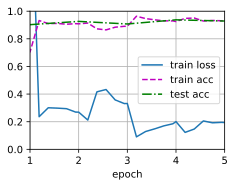

In [15]:
#使用较小的学习率
train_fine_tuning(finetune_net, 5e-5)

loss 0.345, train acc 0.851, test acc 0.850
37.3 examples/sec on [device(type='cuda', index=0)]


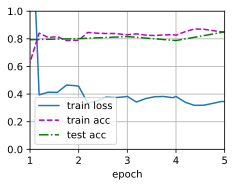

In [16]:
#为了进行比较，我们定义了一个相同的模型，但是将其所有模型参数初始化为随机值。 
# 由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。
# 同时在训练过程且精度会比用预训练好的模型已经在大量的图像上训练过，
# 因此可以提供良好的初始权重，从而加速收敛，
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

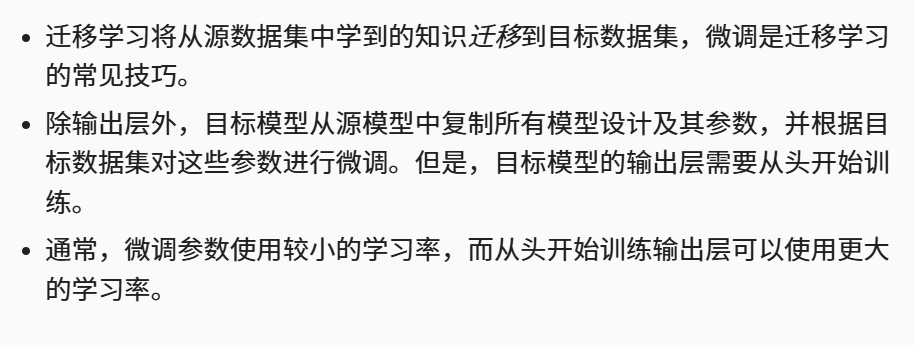